In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch.utils.data import Dataset, random_split
from tqdm.notebook import tqdm #Pretty progress bar
import matplotlib.pyplot as plt

In [4]:
#Make a transformer that preprocceses the data - converts it from images into normalised tensors
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

In [5]:
#Load the MNIST dataset
dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

#Split 80:20
train_data, test_data = random_split(dataset, [int(len(dataset) * 0.8), int(len(dataset) * 0.2)])

#Set train=False for validation
val_data = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

In [6]:
#Create dataloaders: Efficiently loads data in batches
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False)

In [7]:
#Each item in the dataset is in the form (image_tensor 28x28, actual_number)
image_0, label_0 = dataset[0]
print("Train data:", len(train_data))
print("Test data:", len(test_data))
print("Validation data:", len(val_data))
print("Image shape:", image_0.shape, "Label:", label_0)

Train data: 48000
Test data: 12000
Validation data: 10000
Image shape: torch.Size([1, 28, 28]) Label: 5


In [8]:
#Design my model, I'm using a Convolutional Neural Network
class CNN(nn.Module):

    #For neural networks, the layers are defined in the init method.

    def __init__(self, num_classes):
        super(CNN, self).__init__()
        self.layer1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3)
        self.layer2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3)
        self.max_pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
    
        # Dropout after the second convolutional layer
        self.dropout1 = nn.Dropout(p=0.5)
    
        # Flattened size from the 2nd convolutional layer output
        self.fc1 = nn.Linear(32 * 12 * 12, 128)
        
        # Dropout after the first fully connected layer
        self.dropout2 = nn.Dropout(p=0.5)
    
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.max_pool1(out)
        
        # Apply dropout after the second convolutional layer
        out = self.dropout1(out)
        
        out = out.reshape(out.size(0), -1)
        
        out = self.fc1(out)
        
        # Apply dropout after the first fully connected layer
        out = self.dropout2(out)
    
        out = self.fc2(out)
        return out

In [9]:
#Define the model
model = CNN(num_classes=10)

#Set the loss function and optimiser
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)

#Establish a device - whether to run on CPU or GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

CNN(
  (layer1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
  (layer2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (max_pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=4608, out_features=128, bias=True)
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

In [10]:
#Train the model

#Epochs is the number of times the model goes through the dataset
num_epochs = 5
train_losses, val_losses = [], []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    
    for images, labels in tqdm(train_loader, desc='Training loop'):
        #Move to device
        images, labels = images.to(device), labels.to(device)
        
        # Forward pass: Compute predictions
        optimizer.zero_grad()
        predictions = model(images)
        
        # Calculate loss
        loss = criterion(predictions, labels)
        
        # Backward pass: Update weights
        loss.backward()

        optimizer.step()
        running_loss += loss.item() * labels.size(0)
    
    train_loss = running_loss / len(train_loader.dataset)
    train_losses.append(train_loss)
    
    # Validation phase
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc='Validation loop'):
            # Move inputs and labels to the device
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * labels.size(0)
    val_loss = running_loss / len(val_loader.dataset)
    val_losses.append(val_loss)
    print(f"Epoch {epoch+1}/{num_epochs} - Train loss: {train_loss}, Validation loss: {val_loss}")


Training loop:   0%|          | 0/1500 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 1/5 - Train loss: 0.2922183348791053, Validation loss: 0.09831960567124189


Training loop:   0%|          | 0/1500 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 2/5 - Train loss: 0.15006944446265696, Validation loss: 0.08862780807120725


Training loop:   0%|          | 0/1500 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 3/5 - Train loss: 0.13117605279463654, Validation loss: 0.0741825634824112


Training loop:   0%|          | 0/1500 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 4/5 - Train loss: 0.1212599809441405, Validation loss: 0.07421774177383632


Training loop:   0%|          | 0/1500 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 5/5 - Train loss: 0.11362315431144089, Validation loss: 0.07032928127199412


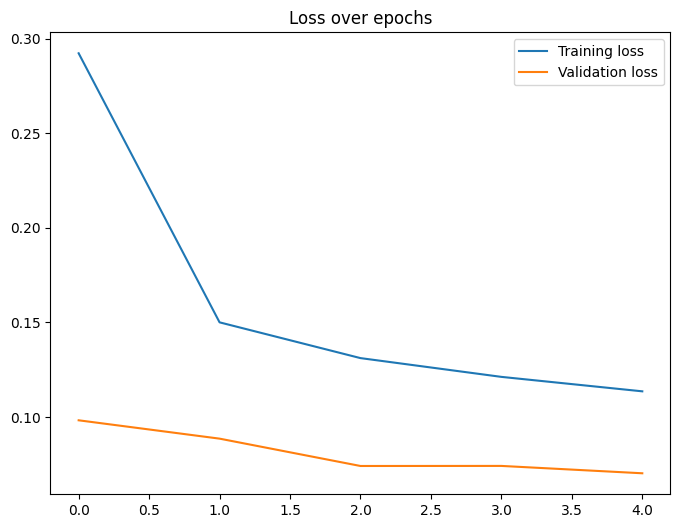

In [11]:
fig, ax = plt.subplots(figsize=(8, 6))
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.legend()
plt.title("Loss over epochs")
plt.show()

# My CNN Notes

---

## **1. Kernel (Filter)**
- A **kernel** (or **filter**) is a small matrix (e.g., 3x3, 5x5) that slides over the input image or feature map to extract features.
- Kernels learn to detect specific patterns, such as edges, textures, or shapes, depending on their weights.
- **Kernel Size**: Defines the dimensions of the kernel (e.g., 3x3, 5x5). Smaller kernels (e.g., 3x3) are commonly used to capture fine-grained features.

---

## **2. In Channels**
- **In Channels** refers to the number of input channels (or feature maps) to a convolutional layer.
- For the **first convolutional layer**, `in_channels = 1` for grayscale images (e.g., MNIST) and `in_channels = 3` for RGB images.
- For subsequent layers, `in_channels` equals the `out_channels` of the previous layer.

---

## **3. Convolutional Layers**
- Convolutional layers apply **kernels** to the input to extract spatial features.
- Key Parameters:
  - `in_channels`: Number of input channels.
  - `out_channels`: Number of filters (kernels) to apply.
  - `kernel_size`: Size of the kernel (e.g., 3x3).
  - `stride`: How many pixels the kernel moves at a time (e.g., 1 or 2).
  - `padding`: Adds extra pixels around the input to control the output size (e.g., "same" or "valid").

---

## **4. Pooling Layers**
- Pooling layers downsample feature maps to reduce spatial dimensions and computational cost.
- Common Types:
  - **Max Pooling**: Takes the maximum value in each window (e.g., 2x2).
  - **Average Pooling**: Takes the average value in each window.
- Key Parameters:
  - `kernel_size`: Size of the pooling window (e.g., 2x2).
  - `stride`: How many pixels the window moves at a time (e.g., 2).

---

## **5. Fully Connected (FC) Layers**
- FC layers are traditional neural network layers where each neuron is connected to all neurons in the previous layer.
- Used at the end of a CNN to combine features and produce the final output (e.g., class probabilities).
- Key Parameters:
  - `in_features`: Number of input features (flattened output from the last convolutional/pooling layer).
  - `out_features`: Number of output features (e.g., number of classes).

---

## **6. Activation Functions**
- Activation functions introduce non-linearity into the model, allowing it to learn complex patterns.
- Common Activation Functions:
  - **ReLU (Rectified Linear Unit)**: